In [1]:
from IPython.display import YouTubeVideo

from os.path import join
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier

import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

In [2]:
from matplotlib import __version__ as mplver


In [3]:
print("matplotlib version is:" , mplver)

matplotlib version is: 3.7.2


## Import preprocessed data

In [4]:
data = pd.read_csv("data_full.csv")

In [5]:
data.set_index("ID", inplace=True)

In [6]:
data.head()

,Age,Income,DaysWithoutFrequency,LifetimeValue,UseByTime,AthleticsActivities,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,...,Active_Period,Contract_Duration,PercentageOfVisits,TotalNumberOfActivities,MonthlyValue,PercentageOfClasses,Freq_Visits_Day,Freq_Classes_Contract,Visits_ActivePeriod,Gender_Female
ID,,,,,,,,,,,,,,,,,,,,,
10000,3.083333,2.674242,-0.600000,-0.278298,0,0.0,0.0,1.0,0.0,0.0,...,0.000000,-0.490868,1.15,0.0,3.017065,1.866571,0.763419,9.579365,-0.201465,1
10001,0.500000,0.500000,0.307692,1.182909,0,0.0,0.0,0.0,0.0,0.0,...,0.989071,0.285388,-0.20,0.0,0.607509,0.104392,-0.204771,0.198413,-0.501832,1
10002,0.000000,0.007576,-0.507692,-0.472264,0,0.0,0.0,1.0,0.0,0.0,...,-0.016393,-0.554795,0.50,0.0,0.493905,0.000000,1.208748,0.000000,0.619048,0
10003,-1.166667,-1.492424,-0.276923,-0.030735,0,0.0,0.0,0.0,1.0,0.0,...,0.989071,-0.257991,0.35,0.0,0.176012,0.239981,0.463221,0.992063,-0.300366,0
10004,1.000000,1.780303,2.615385,0.785607,0,0.0,0.0,1.0,0.0,0.0,...,-0.016393,1.152968,-0.50,0.0,-0.611409,0.000000,-0.255467,0.000000,-0.600733,0


In [7]:
data.columns

Index(['Age', 'Income', 'DaysWithoutFrequency', 'LifetimeValue', 'UseByTime',
       'AthleticsActivities', 'WaterActivities', 'FitnessActivities',
       'TeamActivities', 'RacketActivities', 'CombatActivities',
       'SpecialActivities', 'OtherActivities', 'NumberOfFrequencies',
       'AttendedClasses', 'AllowedWeeklyVisitsBySLA',
       'AllowedNumberOfVisitsBySLA', 'RealNumberOfVisits', 'NumberOfRenewals',
       'HasReferences', 'NumberOfReferences', 'Dropout', 'Active_Period',
       'Contract_Duration', 'PercentageOfVisits', 'TotalNumberOfActivities',
       'MonthlyValue', 'PercentageOfClasses', 'Freq_Visits_Day',
       'Freq_Classes_Contract', 'Visits_ActivePeriod', 'Gender_Female'],
      dtype='object')

In [8]:
metric_features = ['Age','Contract_Duration', 'PercentageOfVisits', 'PercentageOfClasses',
       'Freq_Visits_Day', 'Visits_ActivePeriod']

non_metric_features = data.columns.drop(metric_features).to_list()

### SOM + K-means clustering

### Geral

In [9]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

# Notice that the SOM did not converge - We're under a time constraint for this class
sm = sompy.SOMFactory().build(
    data[metric_features].values, 
    mapsize=[50, 50],  # NEEDS TO BE A LIST
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)

## This will take a few minutes!
# sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)
sm.train(n_job=-1, verbose='info', train_rough_len=50, train_finetune_len=50)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 50

 epoch: 1 ---> elapsed time:  7.707000, quantization error: 1.897285

 epoch: 2 ---> elapsed time:  7.821000, quantization error: 2.154029

 epoch: 3 ---> elapsed time:  7.798000, quantization error: 2.135597

 epoch: 4 ---> elapsed time:  7.758000, quantization error: 2.129141

 epoch: 5 ---> elapsed time:  7.572000, quantization error: 2.124445

 epoch: 6 ---> elapsed time:  8.334000, quantization error: 2.121970

 epoch: 7 ---> elapsed time:  7.792000, quantization error: 2.119714

 epoch: 8 ---> elapsed time:  7.252000, quantization error: 2.117338

 epoch: 9 ---> elapsed time:  6.811000, quantization error: 2.114679

 epoch: 10 ---> elapsed time:  6.066000, quantization error: 2.111622

 epoch: 11 ---> elapsed time:  6.576000, quantization error: 2.108102

 epoch: 12 ---> elapsed time:  7.651000, quantization error: 2.104811

 epoch: 13 ---> 

In [11]:
range_clusters = range(1, 10)

inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=20, random_state=1)
    kmclust.fit(data[metric_features])
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

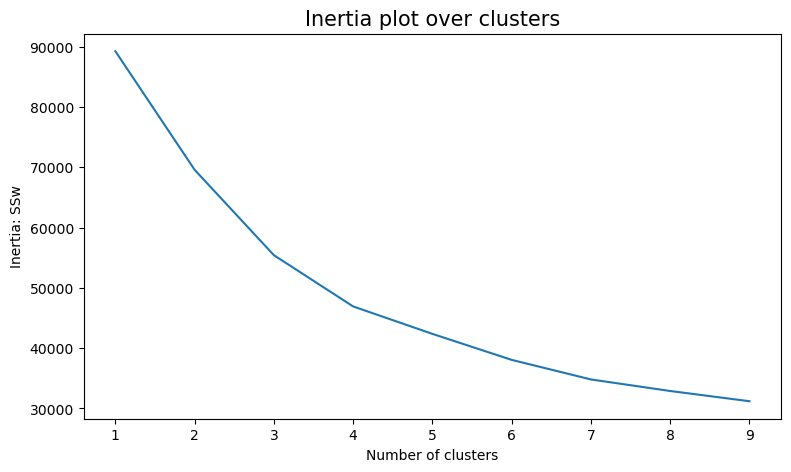

In [12]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

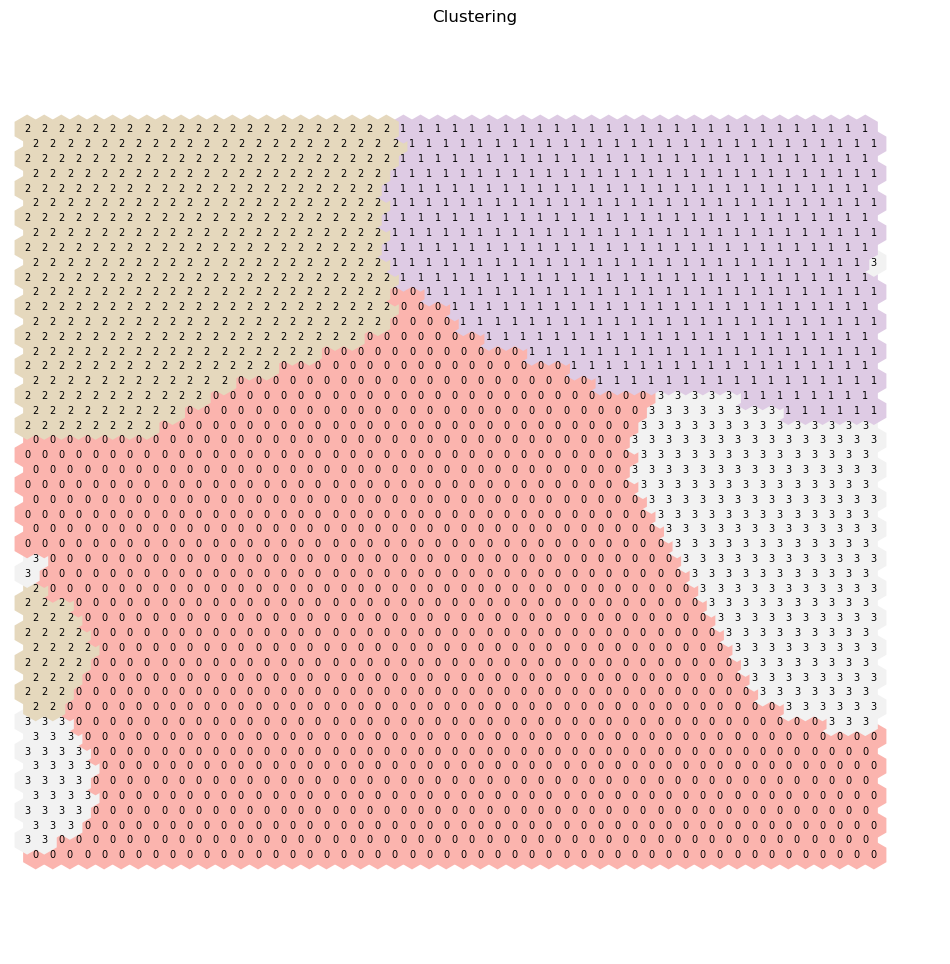

In [13]:
# Perform K-Means clustering on top of the 2500 units (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

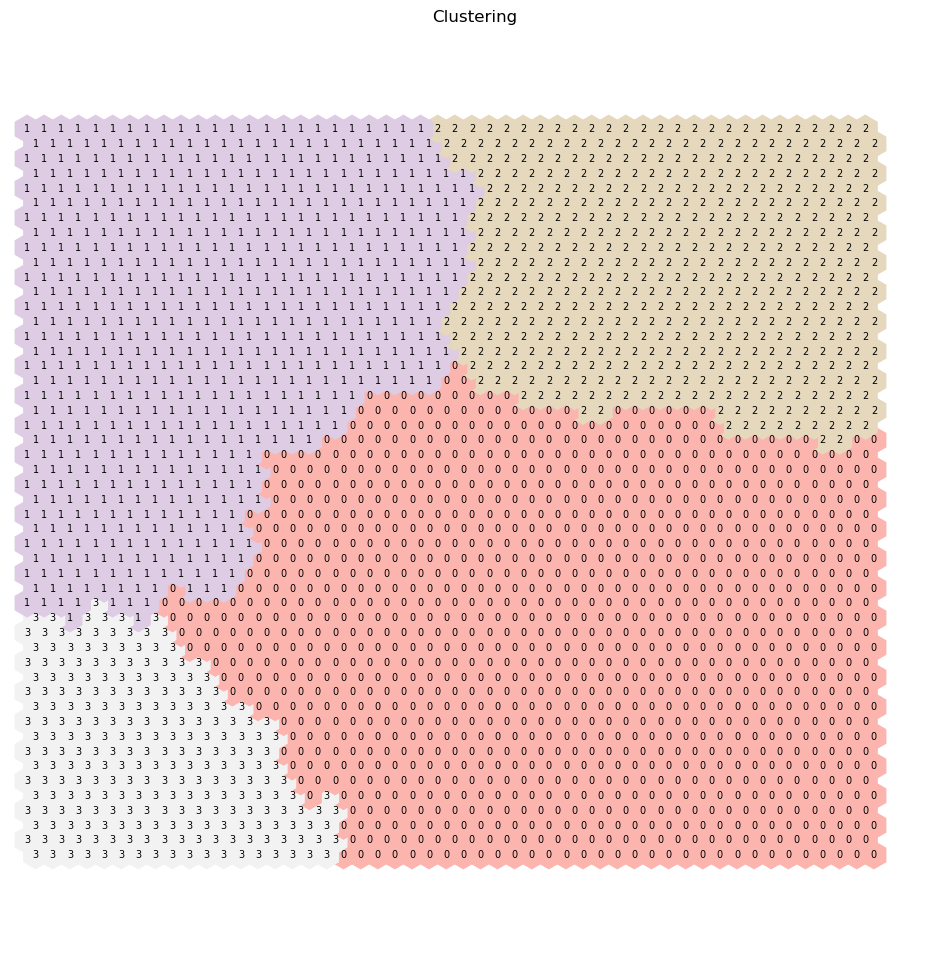

In [14]:

# Perform Hierarchical clustering on top of the 2500 units (sm.get_node_vectors() output)
hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels = hierclust.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [15]:
# Check the nodes and and respective clusters
nodes = sm.codebook.matrix

df_nodes = pd.DataFrame(nodes, columns=metric_features)
df_nodes['label'] = nodeclus_labels
df_nodes

,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod,label
0,0.700221,-0.474186,-0.513141,2.111940,-0.620162,-0.634623,2
1,0.429765,-0.520841,-0.544406,1.943974,-0.636986,-0.661132,2
2,0.127882,-0.561284,-0.613875,1.878301,-0.668371,-0.676154,2
3,-0.147147,-0.583776,-0.663600,1.869800,-0.701928,-0.695927,2
4,-0.408601,-0.556133,-0.672154,1.870983,-0.757444,-0.706714,2
...,...,...,...,...,...,...,...
2495,3.063281,-0.454461,-0.665504,-0.421152,-0.406651,-0.560404,3
2496,2.930224,-0.361394,-0.647206,-0.035587,-0.416302,-0.581603,3
2497,2.657548,-0.216243,-0.599932,0.626108,-0.430783,-0.600921,3
2498,2.450439,-0.087056,-0.576622,1.218043,-0.412450,-0.621372,3


In [16]:
# Obtaining SOM's BMUs labels
bmus_map = sm.find_bmu(data[metric_features])[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((data, np.expand_dims(bmus_map,1)), axis=1),
    index=data.index, columns=np.append(data.columns,"BMU")
)
df_bmus

,Age,Income,DaysWithoutFrequency,LifetimeValue,UseByTime,AthleticsActivities,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,...,Contract_Duration,PercentageOfVisits,TotalNumberOfActivities,MonthlyValue,PercentageOfClasses,Freq_Visits_Day,Freq_Classes_Contract,Visits_ActivePeriod,Gender_Female,BMU
ID,,,,,,,,,,,,,,,,,,,,,
10000,3.083333,2.674242,-0.600000,-0.278298,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.490868,1.15,0.0,3.017065,1.866571,0.763419,9.579365,-0.201465,1.0,327.0
10001,0.500000,0.500000,0.307692,1.182909,0.0,0.0,0.0,0.0,0.0,0.0,...,0.285388,-0.20,0.0,0.607509,0.104392,-0.204771,0.198413,-0.501832,1.0,2050.0
10002,0.000000,0.007576,-0.507692,-0.472264,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.554795,0.50,0.0,0.493905,0.000000,1.208748,0.000000,0.619048,0.0,891.0
10003,-1.166667,-1.492424,-0.276923,-0.030735,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.257991,0.35,0.0,0.176012,0.239981,0.463221,0.992063,-0.300366,0.0,771.0
10004,1.000000,1.780303,2.615385,0.785607,0.0,0.0,0.0,1.0,0.0,0.0,...,1.152968,-0.50,0.0,-0.611409,0.000000,-0.255467,0.000000,-0.600733,0.0,1850.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24937,-0.750000,-1.492424,-0.584615,4.860757,0.0,0.0,1.0,0.0,0.0,0.0,...,1.997717,0.65,0.0,0.585080,2.056875,0.190855,6.634921,1.000000,0.0,903.0
24938,1.333333,1.045455,-0.030769,0.675600,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.027397,-0.25,0.0,0.756216,0.000000,1.391650,0.000000,0.007326,0.0,1598.0
24939,-0.250000,-0.121212,-0.584615,-0.449775,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.554795,0.85,0.0,0.786446,0.000000,1.208748,0.000000,1.025641,0.0,791.0


In [17]:
# Get cluster labels for each observation
df_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)
df_final

,Age,Income,DaysWithoutFrequency,LifetimeValue,UseByTime,AthleticsActivities,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,...,PercentageOfVisits,TotalNumberOfActivities,MonthlyValue,PercentageOfClasses,Freq_Visits_Day,Freq_Classes_Contract,Visits_ActivePeriod,Gender_Female,BMU,label
ID,,,,,,,,,,,,,,,,,,,,,
10000,3.083333,2.674242,-0.600000,-0.278298,0.0,0.0,0.0,1.0,0.0,0.0,...,1.15,0.0,3.017065,1.866571,0.763419,9.579365,-0.201465,1.0,327.0,1
10001,0.500000,0.500000,0.307692,1.182909,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.20,0.0,0.607509,0.104392,-0.204771,0.198413,-0.501832,1.0,2050.0,0
10002,0.000000,0.007576,-0.507692,-0.472264,0.0,0.0,0.0,1.0,0.0,0.0,...,0.50,0.0,0.493905,0.000000,1.208748,0.000000,0.619048,0.0,891.0,1
10003,-1.166667,-1.492424,-0.276923,-0.030735,0.0,0.0,0.0,0.0,1.0,0.0,...,0.35,0.0,0.176012,0.239981,0.463221,0.992063,-0.300366,0.0,771.0,2
10004,1.000000,1.780303,2.615385,0.785607,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.50,0.0,-0.611409,0.000000,-0.255467,0.000000,-0.600733,0.0,1850.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24937,-0.750000,-1.492424,-0.584615,4.860757,0.0,0.0,1.0,0.0,0.0,0.0,...,0.65,0.0,0.585080,2.056875,0.190855,6.634921,1.000000,0.0,903.0,2
24938,1.333333,1.045455,-0.030769,0.675600,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.25,0.0,0.756216,0.000000,1.391650,0.000000,0.007326,0.0,1598.0,1
24939,-0.250000,-0.121212,-0.584615,-0.449775,0.0,0.0,0.0,1.0,0.0,0.0,...,0.85,0.0,0.786446,0.000000,1.208748,0.000000,1.025641,0.0,791.0,1


In [18]:
# Characterizing the final clusters
df_final.drop(columns='BMU').groupby('label').mean()

,Age,Income,DaysWithoutFrequency,LifetimeValue,UseByTime,AthleticsActivities,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,...,Active_Period,Contract_Duration,PercentageOfVisits,TotalNumberOfActivities,MonthlyValue,PercentageOfClasses,Freq_Visits_Day,Freq_Classes_Contract,Visits_ActivePeriod,Gender_Female
label,,,,,,,,,,,,,,,,,,,,,
0,0.068027,0.066077,0.850810,0.194018,0.066117,0.006431,0.136857,0.733521,0.017886,0.002814,...,0.386039,0.362379,-0.159305,0.099879,-0.227999,0.028765,-0.138885,0.077170,-0.123995,0.617363
1,0.367620,0.308840,0.002012,0.338540,0.047529,0.006148,0.212107,0.735635,0.018208,0.026247,...,0.307488,0.126205,1.021223,0.087964,0.228063,0.323644,1.128359,1.460790,1.247430,0.577205
2,-0.798439,-0.933961,0.702836,1.189554,0.018257,0.007067,0.652532,0.110130,0.176678,0.061249,...,0.458611,0.607173,0.244994,0.094523,0.323443,1.809708,-0.170024,3.837416,-0.141801,0.570377
3,2.127225,1.833726,0.511354,0.355920,0.048803,0.011971,0.244015,0.662063,0.015654,0.005985,...,0.399066,0.139650,-0.084968,0.089319,0.314584,0.239275,0.149040,0.560010,-0.032969,0.637201


In [19]:
cluster_means = df_final.groupby('label').mean()[metric_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1)

label,0,1,2,3
Age,0.07,0.37,-0.80,2.13
Contract_Duration,0.36,0.13,0.61,0.14
PercentageOfVisits,-0.16,1.02,0.24,-0.08
PercentageOfClasses,0.03,0.32,1.81,0.24
Freq_Visits_Day,-0.14,1.13,-0.17,0.15
Visits_ActivePeriod,-0.12,1.25,-0.14,-0.03


In [20]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
       
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

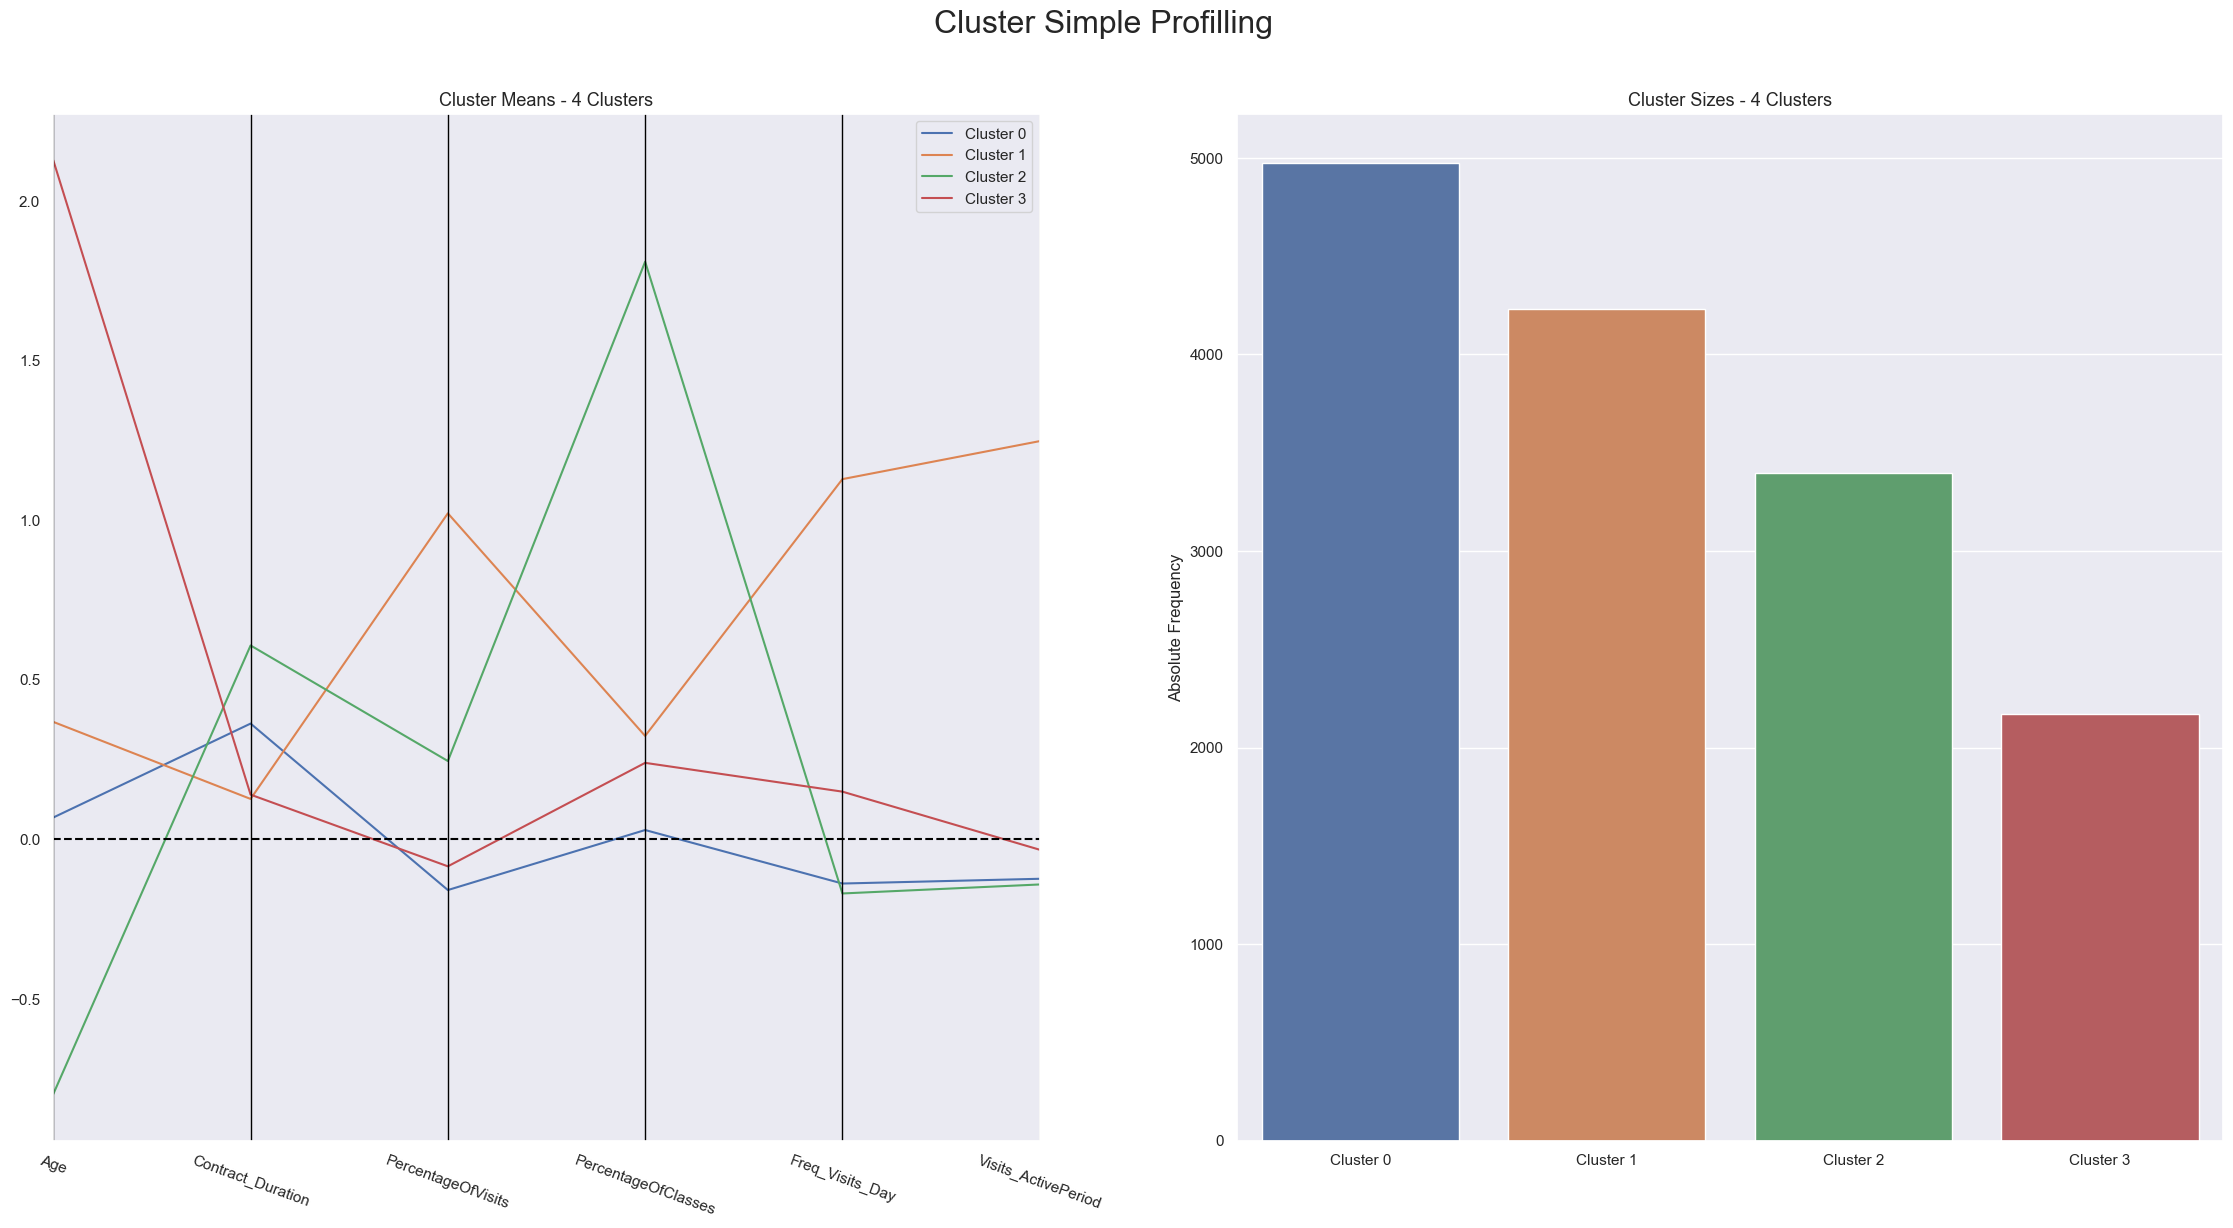

In [21]:
cluster_profiles(
    df = df_final[metric_features + ["label"]], 
    label_columns = ["label"], 
    figsize = (28, 13), 
    compar_titles = [""]
)